In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans

import common.loss_utils as loss_utils

import sys
sys.path.append('../utae-paps')
from src.backbones import utae_mod

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
EXPECTED = 1


In [7]:
_MEDIAN_PIXEL = 216.0
_IQR = 201.0

deltas = np.linspace(-1.0, 1.0, num=41)
_cluster_centers = deltas.reshape(-1,1)

_KM = KMeans()
_KM.cluster_centers_ = _cluster_centers
_KM._n_threads = 1

def transform(x):
    return np.tanh((x - _MEDIAN_PIXEL) / _IQR)

def transform_y(y, starter):
    y = transform(y)
    y = y - starter
    y_grouped = _KM.predict(y.reshape(-1,1))
    y_grouped = y_grouped.reshape(y.shape)
    return y_grouped

In [6]:
model = utae_mod.UTAE(
    input_dim=1, # 10 for paper
    encoder_widths=[64, 64, 64, 128],
    decoder_widths=[32, 32, 64, 128],
    out_conv=[32, len(_cluster_centers)], # [32, 20] for paper
    str_conv_k=4,
    str_conv_s=2,
    str_conv_p=1,
    agg_mode="att_group",
    encoder_norm="group",
    n_head=16,
    d_model=256,
    d_k=4,
    encoder=False,
    return_maps=False,
    pad_value=0,
    padding_mode="reflect",
)

model.load_state_dict(torch.load("weights/utae_300d_imagediffs_epochs=4_loss=0.2302.pt"))
model = model.to(DEVICE)

../utae-paps/src/backbones/positional_encoding.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  T, 2 * (torch.arange(offset, offset + d).float() // 2) / d


In [8]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [9]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [10]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.generator.randint(0, input_slice.shape[1] - 128)

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        x = transform(x)
        x_last = x[-1]
        x = x - x_last
        y_trans = transform_y(y, x_last[32:96,32:96])
        return x, y_trans, x_last, y

    def __len__(self):
        return len(self.times) - 35

BATCH_SIZE=1
ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2,
  )



In [11]:
ex_x, ex_y, _, _ = ds[0]

In [12]:
ex_x.shape, ex_y.shape

((12, 128, 128), (24, 64, 64))

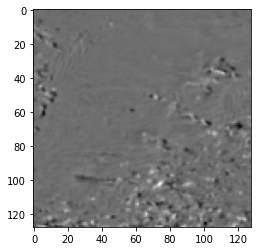

In [13]:
plt.imshow(ex_x[-2], cmap='gray')

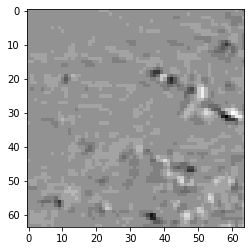

In [14]:
plt.imshow(ex_y[0], cmap='gray')

In [16]:
STOP_BATCH = 500

In [17]:
# get accuracy
model.eval()

running_correct = 0
running_total = 0
bp = torch.Tensor([list(range(12)) for _ in range(BATCH_SIZE)]).to(DEVICE)
for i, (srcs, trgs, _, _) in enumerate(tqdm.tqdm(dl)):
    if i > STOP_BATCH:
        break
    batch_bp = bp[:len(srcs)] # adapt to current batch
    xi = srcs.float().to(DEVICE)
    yi = trgs[:,:EXPECTED].long().to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi, batch_positions=bp)
    
    # remove the batch and satellite channel dimension from the prediction
    preds = torch.squeeze(preds, dim=2)
    # get argmax of the predicted labels
    preds = torch.argmax(preds, dim=1)
    running_correct += (preds == yi).sum()
    running_total += yi.reshape(-1).shape[0]
    

  3%|▎         | 501/18319 [00:52<30:49,  9.63it/s] 


In [21]:
running_correct / running_total

tensor(0.4457, device='cuda:0')

In [22]:
_means = torch.FloatTensor(_cluster_centers).to(DEVICE)
_means = torch.unsqueeze(torch.unsqueeze(_means, 0), 3)

def get_img(preds):
    a = torch.exp(preds)
    v = a.sum(dim=1)
    e = a / torch.unsqueeze(v, 1)
    r = torch.sum(e * _means, axis=1)
    return r

In [23]:
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=EXPECTED)


In [24]:
model.eval()

losses = []
bp = torch.Tensor([list(range(12)) for _ in range(BATCH_SIZE)]).to(DEVICE)
for i, (srcs, _, x_last, trgs) in enumerate(tqdm.tqdm(dl)):
    if i > STOP_BATCH:
        break
    batch_bp = bp[:len(srcs)] # adapt to current batch
    xi = srcs.float().to(DEVICE)
    yi = trgs[:,:EXPECTED].float().to(DEVICE)
    x_last = x_last.float().to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi, batch_positions=bp)
    
    # remove the batch and satellite channel dimension from the prediction
    preds = torch.squeeze(preds, dim=2)
    preds = torch.squeeze(preds, dim=0)
    preds = get_img(preds)
    preds = preds + x_last[:,32:96,32:96]
    preds[preds > 1] = 0.999
    preds[preds < -1] = -0.999
    preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL
    
#     missing = EXPECTED - FORECAST
#     # just do persistence
#     missing_pred = inv_transform(xi[:,-1,:,32:96,32:96])
#     missing_pred = torch.squeeze(missing_pred)
#     missing_pred = torch.tile(missing_pred, (missing, 1, 1))
#     # stack them together
#     preds = torch.cat([preds, missing_pred], dim=0)

    # OR, just test the ones we did
#     yi = yi[:FORECAST]
    
    # also need to do this
    preds = torch.unsqueeze(preds, dim=0)
    loss = criterion(preds, yi)
    itm = loss.item()
    if np.isnan(itm):
        break
    losses.append(itm)

  3%|▎         | 501/18319 [01:03<37:40,  7.88it/s]


In [25]:
np.mean(losses)

0.8941306727613042

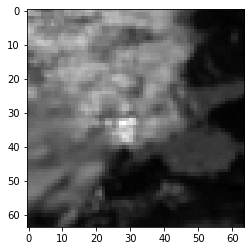

In [26]:
plt.imshow(preds[0,0].detach().cpu().numpy(), cmap='gray')

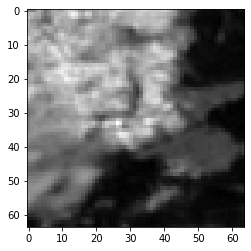

In [27]:
plt.imshow(yi[0,0].detach().cpu().numpy(), cmap='gray')